In [0]:
!pip install tensorflow==1.15.0 tensorflow-datasets==2.1.0
!pip install tabulate

In [0]:
pip uninstall -y h5py

Python interpreter will be restarted.
Found existing installation: h5py 3.7.0
Not uninstalling h5py at /databricks/python3/lib/python3.7/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-5164aaf8-97a9-4952-8cae-fcc7554fe58d
Can't uninstall 'h5py'. No files were found to uninstall.
Python interpreter will be restarted.

In [0]:
pip install 'h5py==2.10.0'

Python interpreter will be restarted.
Collecting h5py==2.10.0
 Downloading h5py-2.10.0-cp37-cp37m-manylinux1_x86_64.whl (2.9 MB)
Requirement already satisfied: numpy>=1.7 in /databricks/python3/lib/python3.7/site-packages (from h5py==2.10.0) (1.18.1)
Requirement already satisfied: six in /databricks/python3/lib/python3.7/site-packages (from h5py==2.10.0) (1.14.0)
Installing collected packages: h5py
 Attempting uninstall: h5py
 Found existing installation: h5py 3.7.0
 Not uninstalling h5py at /databricks/python3/lib/python3.7/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-5164aaf8-97a9-4952-8cae-fcc7554fe58d
 Can't uninstall 'h5py'. No files were found to uninstall.
Successfully installed h5py-2.10.0
WARNING: You are using pip version 20.0.2; however, version 22.2.2 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-5164aaf8-97a9-4952-8cae-fcc7554fe58d/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
pip install keras-nightly

Python interpreter will be restarted.
Collecting keras-nightly
 Downloading keras_nightly-2.11.0.dev2022091807-py2.py3-none-any.whl (1.7 MB)
Installing collected packages: keras-nightly
Successfully installed keras-nightly-2.11.0.dev2022091807
WARNING: You are using pip version 20.0.2; however, version 22.2.2 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-5164aaf8-97a9-4952-8cae-fcc7554fe58d/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
!pip uninstall keras-nightly
!pip uninstall -y tensorflow
!pip install keras==2.1.6
!pip install tensorflow==1.15.0
!pip install tensorflow-datasets==3.2.1
!pip install h5py==2.10.0

### Imports

In [0]:
import argparse
import matplotlib.pyplot as plt
from tensorflow import keras
from bigdl.orca import init_orca_context, stop_orca_context
from bigdl.orca.learn.tf.estimator import Estimator
from bigdl.orca import OrcaContext
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime
import time
from bigdl.orca.learn.tf.estimator import Estimator
from tabulate import tabulate
OrcaContext.log_output = False
# OrcaContext.log_output = True # recommended to set it to True when running BigDL in Jupyter notebook (this will display terminal's  stdout and stderr in the Jupyter notebook).

Prepending /databricks/python/lib/python3.7/site-packages/bigdl/share/dllib/conf/spark-bigdl.conf to sys.path
WARNING:tensorflow:From /databricks/python/lib/python3.7/site-packages/bigdl/orca/tfpark/zoo_optimizer.py:73: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

/databricks/python/lib/python3.7/site-packages/bigdl/dllib/utils/nncontext.py:289: UserWarning: Setting log_output takes no effect after the context has been initialized. You need to set log_output before initializing the context (e.g., before calling init_orca_context, init_nncontext, etc.)
 warnings.warn(msg)

## Utils

In [0]:
def train_test(model=None, train_data=None, test_data=None, preprocess=None, output_model_name=None, save_model=False, epochs=1, cluster_mode="spark-submit", num_nodes=2, cores=2):
    init_orca_context(cluster_mode=cluster_mode, num_modes=min(3, num_nodes), cores=min(4, cores))
    if not model:
        model = keras.Sequential(
        [keras.layers.Conv2D(20, kernel_size=(5, 5), strides=(1, 1), activation='tanh',
                             input_shape=(28, 28, 1), padding='valid'),
         keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
         keras.layers.Conv2D(50, kernel_size=(5, 5), strides=(1, 1), activation='tanh',
                             padding='valid'),
         keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding='valid'),
         keras.layers.Flatten(),
         keras.layers.Dense(500, activation='tanh'),
         keras.layers.Dense(10, activation='softmax'),
         ]
        )

        model.compile(optimizer=keras.optimizers.RMSprop(),
          loss='sparse_categorical_crossentropy',
          metrics=['accuracy'])
    if not (train_data or test_data):
        if not preprocess:
            def preprocess(data):
              data['image'] = tf.cast(data["image"], tf.float32) / 255.
              return data['image'], data['label']

        # get DataSet
        train_data = tfds.load(name="mnist", split="train", data_dir="gs://tfds-data/datasets")
        test_data = tfds.load(name="mnist", split="test", data_dir="gs://tfds-data/datasets")

        train_data = train_data.map(preprocess)
        test_data = test_data.map(preprocess)
    
    # Disable AutoShard.
    options = tf.data.Options()
    options.experimental_distribute.auto_shard = False
    train_data = train_data.with_options(options)
    test_data = test_data.with_options(options)
    
    est = Estimator.from_keras(keras_model=model)
    #This will come as an argument for the Function
    #validation_data will be given as an argument in the Function
    tic = time.time()
    est.fit(
        data=train_data,
        batch_size=320,
        epochs=epochs,
        validation_data=test_data
    )
    tac = time.time()
    fit_time = tac-tic
    # evaluate and print result
    # result = est.evaluate(test_data)
    # print(result)
    output_name = "/tmp/" + (f"{output_model_name+str(datetime.datetime.now()) if output_model_name else str(datetime.datetime.now())}.h5")
    output_name = output_name.replace(" ", "_")
    if save_model:
        est.save_keras_model(output_name)
    # return output_name, fit_time, est
    return output_name, fit_time

def save_output(output_model_name, time, result_estimator):
    print(f"Saving output to: {output_model_name}")
    
def visualize_output(output_model_name):
    print(f"Visualizing from: {output_model_name}")

def train_test_save(model=None, train_data=None, test_data=None, preprocess=None, output_model_name=None, save_model=False, epochs=10, cluster_mode="spark-submit", num_nodes=2, cores=2):
    output_model_name, fit_time = train_test(
        model=model,
        train_data=train_data,
        test_data=test_data,
        preprocess=preprocess,
        output_model_name=output_model_name,
        epochs=epochs,
        cluster_mode=cluster_mode,
        num_nodes=num_nodes,
        cores=cores,
        save_model=save_model
    )
    print(f"---->>> {output_model_name}, {num_nodes} nodes, {cores} cores, fitted after {fit_time}sec")
    save_output(output_model_name, time, None)
    visualize_output(output_model_name)
    return output_model_name, fit_time

def grid_search(model=None, train_data=None, test_data=None, preprocess=None, output_model_name=None, save_model=False, epochs=10, cluster_mode="spark-submit", min_num_nodes=2, max_num_nodes=3, min_cores=1, max_cores=4):
    results = []
    assert min_num_nodes<=max_num_nodes
    assert min_cores<=max_cores
    for num_nodes in range(min_num_nodes, max_num_nodes):
        for cores in range(min_cores, max_cores):
            model_name, fit_time = train_test_save(
                model=model,
                train_data=train_data,
                test_data=test_data,
                preprocess=preprocess,
                output_model_name=output_model_name,
                epochs=epochs,
                cluster_mode=cluster_mode,
                num_nodes=num_nodes,
                cores=cores,
                save_model=save_model
            )
            results.append((model_name, num_nodes, cores, fit_time))
    return results

def visualize_grid_search(model_name, epochs, results):
    xs, ys = [], []
    for datum in results:
        name, nodes, cores, fit_time = datum
        xs.append(f"{nodes}, {cores}")
        ys.append(fit_time/1000)
        plt.bar(xs, ys)
    items = zip(xs, ys)
    print(items)
    print(xs, ys)
    print(tabulate(items, tablefmt="github"))
    plt.title(f"{model_name}: {epochs} epochs")
    plt.xlabel("Nodes, Cores")
    plt.ylabel("Train time (*10^3 sec)")
    plt.plot()

def tabulate_grid_search(model_name, epochs, results):
    xs, ys = [], []
    for datum in results:
        name, nodes, cores, fit_time = datum
        xs.append(f"{nodes}, {cores}")
        ys.append(fit_time)
    items = zip(xs, ys)
    print(model_name)
    print(tabulate(items, tablefmt="github", headers=["Nodes, Cores", "fit_time (sec)"]))

### Datasets

In [0]:
## MNIST
def preprocess(data):
    data['image'] = tf.cast(data["image"], tf.float32) / 255.
    data['image'] = tf.image.resize(data["image"], (72, 72))
    data['image'] = tf.image.grayscale_to_rgb(data["image"])
    return data['image'], data['label']

# get DataSet
train_data_mnist = tfds.load(name="mnist", split="train", data_dir="gs://mybucket-bigdl-ece-ntua")
#train_data_mnist = tfds.load(name="mnist", split="train", data_dir="gs://tfds-data/datasets")
test_data_mnist = tfds.load(name="mnist", split="test",  data_dir="gs://mybucket-bigdl-ece-ntua")
#test_data_mnist = tfds.load(name="mnist", split="test",  data_dir="gs://tfds-data/datasets")

train_data_mnist = train_data_mnist.map(preprocess)
test_data_mnist = test_data_mnist.map(preprocess)

In [0]:
train_data_mnist

Out[4]: <DatasetV1Adapter shapes: ((72, 72, 3), ()), types: (tf.float32, tf.int64)>

In [0]:
## Camelyon
def preprocess_camelyon(data):
    data['image'] = tf.cast(data["image"], tf.float32) / 255.
    """data['image'] = tf.image.resize(data["image"], (72, 72))
    data['image'] = tf.image.grayscale_to_rgb(data["image"])"""
    return data['image'], data['label']

train_data = tfds.load(name="patch_camelyon", split="train",  data_dir="gs://mybucket-bigdl-ece-ntua")
test_data = tfds.load(name="patch_camelyon", split="test",  data_dir="gs://mybucket-bigdl-ece-ntua")

train_data = train_data.map(preprocess_camelyon)
test_data = test_data.map(preprocess_camelyon)


In [0]:
train_data

Out[6]: <DatasetV1Adapter shapes: ((96, 96, 3), ()), types: (tf.float32, tf.int64)>

## Fine-tuning utils

In [0]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import Xception, MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten, GlobalAveragePooling1D, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop

def init_train_model(base_model_object=MobileNetV2, name="MobileNetV2", min_num_nodes=1, max_num_nodes=2, min_cores=2, max_cores=3, epochs=1, train_data=train_data_mnist, test_data=test_data_mnist):
    # create the base pre-trained model
    base_model = base_model_object(weights='imagenet', include_top=False)
    # model = Xception(weights='imagenet', include_top=False, input_shape=(28, 28, 3))

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(10, activation='softmax')(x)
    # this is the model we will train
    model = Model(inputs=base_model.input, outputs=predictions)
    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional layers
    for layer in base_model.layers:
        layer.trainable = False
    # compile the model (should be done *after* setting layers to non-trainable)
    # model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

    results_init = grid_search(
        model=model,
        train_data=train_data,
        test_data=test_data,
        min_num_nodes=min_num_nodes,
        max_num_nodes=max_num_nodes,
        min_cores=min_cores,
        max_cores=max_cores,
        epochs=epochs,
        output_model_name=name
    )
    return base_model, model, results_init

def fine_tune(base_model, model, frozen_layers_index, train_data=train_data_mnist, test_data=test_data_mnist, min_num_nodes=2, max_num_nodes=4, min_cores=4, max_cores=5, epochs=2, output_model_name="MobileNetV2-fine"):
    # at this point, the top layers are well trained and we can start fine-tuning convolutional layers
    # convolutional layers We will freeze the bottom N layers and train the remaining top layers

    # let's visualize layer names and layer indices to see how many layers
    # we should freeze:
    for i, layer in enumerate(base_model.layers):
       print(i, layer.name)

    # freeze the first (n) layers and unfreeze the rest
    for layer in model.layers[:frozen_layers_index]:
       layer.trainable = False
    for layer in model.layers[frozen_layers_index:]:
       layer.trainable = True

    # we need to recompile the model for these modifications to take effect
    # we use SGD with a low learning rate
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

    results_fine_tuning = grid_search(
        model=model,
        train_data=train_data,
        test_data=test_data,
        min_num_nodes=min_num_nodes,
        max_num_nodes=max_num_nodes,
        min_cores=min_cores,
        max_cores=max_cores,
        epochs=epochs,
        output_model_name=output_model_name
    )
    
    return results_fine_tuning

## Fine-tuning for 1 epoch

In [0]:
name = "MobileNetV2"
base_model_object = MobileNetV2

init_epochs = 1
init_min_num_nodes = 2
init_max_num_nodes = 3
init_min_cores = 4
init_max_cores = 5

fine_tuning_epochs = 1
fine_tuning_min_num_nodes = 1
fine_tuning_max_num_nodes = 4
fine_tuning_min_cores = 4
fine_tuning_max_cores = 5
frozen_layers_index = 133

current_training_data = train_data_mnist
current_test_data = test_data_mnist

base_model, model, results_init = init_train_model(
    base_model_object=base_model_object,
    name=name,
    min_num_nodes=init_min_num_nodes,
    max_num_nodes=init_max_num_nodes,
    min_cores=init_min_cores,
    max_cores=init_max_cores,
    epochs=init_epochs,
    train_data=current_training_data,
    test_data=current_test_data
)

results_fine_tuning = fine_tune(
    base_model=base_model,
    model=model,
    frozen_layers_index=frozen_layers_index,
    train_data=current_training_data,
    test_data=current_test_data,
    min_num_nodes=fine_tuning_min_num_nodes,
    max_num_nodes=fine_tuning_max_num_nodes,
    min_cores=fine_tuning_min_cores,
    max_cores=fine_tuning_max_cores,
    epochs=fine_tuning_epochs,
    output_model_name=name,
)

/databricks/python/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
 warnings.warn('`input_shape` is undefined or non-square, '
Initializing orca context
creating: createFakeOptimMethod
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
INFO:tensorflow:Restoring parameters from /tmp/tmpnuxk7qbw/model
INFO:tensorflow:Restoring parameters from /tmp/tmpnuxk7qbw/model
---->>> /tmp/MobileNetV22022-09-17_17:26:31.604025.h5, 2 nodes, 4 cores, fitted after 383.0546815395355sec
Saving output to: /tmp/MobileNetV22022-09-17_17:26:31.604025.h5
Visualizing from: /tmp/MobileNetV22022-09-17_17:26:31.604025.h5
0 input_2
1 Conv1_pad
2 Conv1
3 bn_Conv1
4 Conv1_relu
5 expanded_conv_depthwise
6 expanded_conv_depthwise_BN
7 expanded_conv_depthwise_relu
8 expanded_conv_project
9 expanded_conv_project_BN
10 block_1_expand
11 block_1_expand_BN
12 block_1_expand_relu
13 block_1_pad
14 block_1_depthwise
15 block_1_depthwise_BN
16 block_1_depthwise_relu
17 block_1_project
18 block_1_project_BN
19 block_2_expand
20 block_2_expand_BN
21 block_2_expand_relu
22 block_2_depthwise
23 block_2_depthwise_BN
24 block_2_depthwise_relu
25 block_2_project
26 block_2_project_BN
27 block_2_add
28 block_3_expand
29 block_3_expand_BN
30 block_3_expand_relu
31 block_3_pad
32 block_3_depthwise
33 block_3_depthwise_BN
34 block_3_depthwise_relu
35 block_3_project
36 block_3_project_BN
37 block_4_expand
38 block_4_expand_BN
39 block_4_expand_relu
40 block_4_depthwise
41 block_4_depthwise_BN
42 block_4_depthwise_relu
43 block_4_project
44 block_4_project_BN
45 block_4_add
46 block_5_expand
47 block_5_expand_BN
48 block_5_expand_relu
49 block_5_depthwise
50 block_5_depthwise_BN
51 block_5_depthwise_relu
52 block_5_project
53 block_5_project_BN
54 block_5_add
55 block_6_expand
56 block_6_expand_BN
57 block_6_expand_relu
58 block_6_pad
59 block_6_depthwise
60 block_6_depthwise_BN
61 block_6_depthwise_relu
62 block_6_project
63 block_6_project_BN
64 block_7_expand
65 block_7_expand_BN
66 block_7_expand_relu
67 block_7_depthwise
68 block_7_depthwise_BN
69 block_7_depthwise_relu
70 block_7_project
71 block_7_project_BN
72 block_7_add
73 block_8_expand
74 block_8_expand_BN
75 block_8_expand_relu
76 block_8_depthwise
77 block_8_depthwise_BN
78 block_8_depthwise_relu
79 block_8_project
80 block_8_project_BN
81 block_8_add
82 block_9_expand
83 block_9_expand_BN
84 block_9_expand_relu
85 block_9_depthwise
86 block_9_depthwise_BN
87 block_9_depthwise_relu
88 block_9_project
89 block_9_project_BN
90 block_9_add
91 block_10_expand
92 block_10_expand_BN
93 block_10_expand_relu
94 block_10_depthwise
95 block_10_depthwise_BN
96 block_10_depthwise_relu
97 block_10_project
98 block_10_project_BN
99 block_11_expand
100 block_11_expand_BN
101 block_11_expand_relu
102 block_11_depthwise
103 block_11_depthwise_BN
104 block_11_depthwise_relu
105 block_11_project
106 block_11_project_BN
107 block_11_add
108 block_12_expand
109 block_12_expand_BN
110 block_12_expand_relu
111 block_12_depthwise
112 block_12_depthwise_BN
113 block_12_depthwise_relu
114 block_12_project
115 block_12_project_BN
116 block_12_add
117 block_13_expand
118 block_13_expand_BN
119 block_13_expand_relu
120 block_13_pad
121 block_13_depthwise
122 block_13_depthwise_BN
123 block_13_depthwise_relu
124 block_13_project
125 block_13_project_BN
126 block_14_expand
127 block_14_expand_BN
128 block_14_expand_relu
129 block_14_depthwise
130 block_14_depthwise_BN
131 block_14_depthwise_relu
132 block_14_project
133 block_14_project_BN
134 block_14_add
135 block_15_expand
136 block_15_expand_BN
137 block_15_expand_relu
138 block_15_depthwise
139 block_15_depthwise_BN
140 block_15_depthwise_relu
141 block_15_project
142 block_15_project_BN
143 block_15_add
144 block_

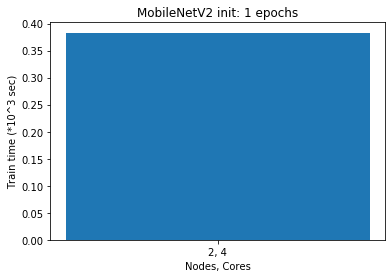

In [0]:
visualize_grid_search(f"{name} init", init_epochs, results_init)

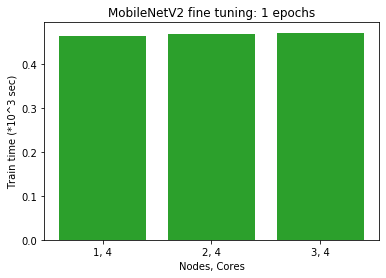

In [0]:
visualize_grid_search(f"{name} fine tuning", fine_tuning_epochs, results_fine_tuning)

In [0]:
tabulate_grid_search(f"{name} fine tuning", fine_tuning_epochs, results_fine_tuning)

MobileNetV2 fine tuning
 Nodes, Cores | fit_time (sec) |
----------------|------------------|
 1, 4 | 465.353 |
 2, 4 | 470.573 |
 3, 4 | 472.399 |

## Fine-tuning for 2 epochs

In [0]:
name = "MobileNetV2"
base_model_object = MobileNetV2

init_epochs = 1
init_min_num_nodes = 2
init_max_num_nodes = 3
init_min_cores = 4
init_max_cores = 5

fine_tuning_epochs = 2
fine_tuning_min_num_nodes = 1
fine_tuning_max_num_nodes = 4
fine_tuning_min_cores = 4
fine_tuning_max_cores = 5
frozen_layers_index = 133

current_training_data = train_data_mnist
current_test_data = test_data_mnist

base_model2, model2, results_init2 = init_train_model(
    base_model_object=base_model_object,
    name=name,
    min_num_nodes=init_min_num_nodes,
    max_num_nodes=init_max_num_nodes,
    min_cores=init_min_cores,
    max_cores=init_max_cores,
    epochs=init_epochs,
    train_data=current_training_data,
    test_data=current_test_data
)

results_fine_tuning2 = fine_tune(
    base_model=base_model2,
    model=model2,
    frozen_layers_index=frozen_layers_index,
    train_data=current_training_data,
    test_data=current_test_data,
    min_num_nodes=fine_tuning_min_num_nodes,
    max_num_nodes=fine_tuning_max_num_nodes,
    min_cores=fine_tuning_min_cores,
    max_cores=fine_tuning_max_cores,
    epochs=fine_tuning_epochs,
    output_model_name=name,
)

/databricks/python/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
 warnings.warn('`input_shape` is undefined or non-square, '
Initializing orca context
creating: createFakeOptimMethod
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
INFO:tensorflow:Restoring parameters from /tmp/tmpu4hrmj0j/model
INFO:tensorflow:Restoring parameters from /tmp/tmpu4hrmj0j/model
---->>> /tmp/MobileNetV22022-09-17_18:08:53.800864.h5, 2 nodes, 4 cores, fitted after 411.4155707359314sec
Saving output to: /tmp/MobileNetV22022-09-17_18:08:53.800864.h5
Visualizing from: /tmp/MobileNetV22022-09-17_18:08:53.800864.h5
0 input_3
1 Conv1_pad
2 Conv1
3 bn_Conv1
4 Conv1_relu
5 expanded_conv_depthwise
6 expanded_conv_depthwise_BN
7 expanded_conv_depthwise_relu
8 expanded_conv_project
9 expanded_conv_project_BN
10 block_1_expand
11 block_1_expand_BN
12 block_1_expand_relu
13 block_1_pad
14 block_1_depthwise
15 block_1_depthwise_BN
16 block_1_depthwise_relu
17 block_1_project
18 block_1_project_BN
19 block_2_expand
20 block_2_expand_BN
21 block_2_expand_relu
22 block_2_depthwise
23 block_2_depthwise_BN
24 block_2_depthwise_relu
25 block_2_project
26 block_2_project_BN
27 block_2_add
28 block_3_expand
29 block_3_expand_BN
30 block_3_expand_relu
31 block_3_pad
32 block_3_depthwise
33 block_3_depthwise_BN
34 block_3_depthwise_relu
35 block_3_project
36 block_3_project_BN
37 block_4_expand
38 block_4_expand_BN
39 block_4_expand_relu
40 block_4_depthwise
41 block_4_depthwise_BN
42 block_4_depthwise_relu
43 block_4_project
44 block_4_project_BN
45 block_4_add
46 block_5_expand
47 block_5_expand_BN
48 block_5_expand_relu
49 block_5_depthwise
50 block_5_depthwise_BN
51 block_5_depthwise_relu
52 block_5_project
53 block_5_project_BN
54 block_5_add
55 block_6_expand
56 block_6_expand_BN
57 block_6_expand_relu
58 block_6_pad
59 block_6_depthwise
60 block_6_depthwise_BN
61 block_6_depthwise_relu
62 block_6_project
63 block_6_project_BN
64 block_7_expand
65 block_7_expand_BN
66 block_7_expand_relu
67 block_7_depthwise
68 block_7_depthwise_BN
69 block_7_depthwise_relu
70 block_7_project
71 block_7_project_BN
72 block_7_add
73 block_8_expand
74 block_8_expand_BN
75 block_8_expand_relu
76 block_8_depthwise
77 block_8_depthwise_BN
78 block_8_depthwise_relu
79 block_8_project
80 block_8_project_BN
81 block_8_add
82 block_9_expand
83 block_9_expand_BN
84 block_9_expand_relu
85 block_9_depthwise
86 block_9_depthwise_BN
87 block_9_depthwise_relu
88 block_9_project
89 block_9_project_BN
90 block_9_add
91 block_10_expand
92 block_10_expand_BN
93 block_10_expand_relu
94 block_10_depthwise
95 block_10_depthwise_BN
96 block_10_depthwise_relu
97 block_10_project
98 block_10_project_BN
99 block_11_expand
100 block_11_expand_BN
101 block_11_expand_relu
102 block_11_depthwise
103 block_11_depthwise_BN
104 block_11_depthwise_relu
105 block_11_project
106 block_11_project_BN
107 block_11_add
108 block_12_expand
109 block_12_expand_BN
110 block_12_expand_relu
111 block_12_depthwise
112 block_12_depthwise_BN
113 block_12_depthwise_relu
114 block_12_project
115 block_12_project_BN
116 block_12_add
117 block_13_expand
118 block_13_expand_BN
119 block_13_expand_relu
120 block_13_pad
121 block_13_depthwise
122 block_13_depthwise_BN
123 block_13_depthwise_relu
124 block_13_project
125 block_13_project_BN
126 block_14_expand
127 block_14_expand_BN
128 block_14_expand_relu
129 block_14_depthwise
130 block_14_depthwise_BN
131 block_14_depthwise_relu
132 block_14_project
133 block_14_project_BN
134 block_14_add
135 block_15_expand
136 block_15_expand_BN
137 block_15_expand_relu
138 block_15_depthwise
139 block_15_depthwise_BN
140 block_15_depthwise_relu
141 block_15_project
142 block_15_project_BN
143 block_15_add
144 block_

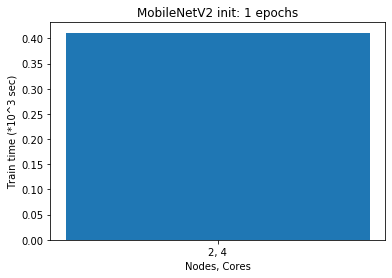

In [0]:
visualize_grid_search(f"{name} init", init_epochs, results_init2)

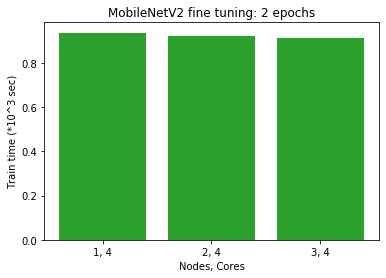

In [0]:
visualize_grid_search(f"{name} fine tuning", fine_tuning_epochs, results_fine_tuning2)

In [0]:
tabulate_grid_search(f"{name} fine tuning", fine_tuning_epochs, results_fine_tuning2)

MobileNetV2 fine tuning
 Nodes, Cores | fit_time (sec) |
----------------|------------------|
 1, 4 | 935.457 |
 2, 4 | 919.867 |
 3, 4 | 911.076 |

## Fine tuning for 4 epochs

In [0]:
name = "MobileNetV2"
base_model_object = MobileNetV2

init_epochs = 1
init_min_num_nodes = 2
init_max_num_nodes = 3
init_min_cores = 4
init_max_cores = 5

fine_tuning_epochs = 4
fine_tuning_min_num_nodes = 1
fine_tuning_max_num_nodes = 4
fine_tuning_min_cores = 4
fine_tuning_max_cores = 5
frozen_layers_index = 133

current_training_data = train_data_mnist
current_test_data = test_data_mnist

base_model4, model4, results_init4 = init_train_model(
    base_model_object=base_model_object,
    name=name,
    min_num_nodes=init_min_num_nodes,
    max_num_nodes=init_max_num_nodes,
    min_cores=init_min_cores,
    max_cores=init_max_cores,
    epochs=init_epochs,
    train_data=current_training_data,
    test_data=current_test_data
)

results_fine_tuning4 = fine_tune(
    base_model=base_model4,
    model=model4,
    frozen_layers_index=frozen_layers_index,
    train_data=current_training_data,
    test_data=current_test_data,
    min_num_nodes=fine_tuning_min_num_nodes,
    max_num_nodes=fine_tuning_max_num_nodes,
    min_cores=fine_tuning_min_cores,
    max_cores=fine_tuning_max_cores,
    epochs=fine_tuning_epochs,
    output_model_name=name,
)

/databricks/python/lib/python3.7/site-packages/keras_applications/mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
 warnings.warn('`input_shape` is undefined or non-square, '
Initializing orca context
creating: createFakeOptimMethod
creating: createTFTrainingHelper
creating: createIdentityCriterion
creating: createEstimator
creating: createMaxEpoch
creating: createEveryEpoch
INFO:tensorflow:Restoring parameters from /tmp/tmpbx4ibl97/model
INFO:tensorflow:Restoring parameters from /tmp/tmpbx4ibl97/model
---->>> /tmp/MobileNetV22022-09-17_19:10:00.318697.h5, 2 nodes, 4 cores, fitted after 472.14146995544434sec
Saving output to: /tmp/MobileNetV22022-09-17_19:10:00.318697.h5
Visualizing from: /tmp/MobileNetV22022-09-17_19:10:00.318697.h5
0 input_4
1 Conv1_pad
2 Conv1
3 bn_Conv1
4 Conv1_relu
5 expanded_conv_depthwise
6 expanded_conv_depthwise_BN
7 expanded_conv_depthwise_relu
8 expanded_conv_project
9 expanded_conv_project_BN
10 block_1_expand
11 block_1_expand_BN
12 block_1_expand_relu
13 block_1_pad
14 block_1_depthwise
15 block_1_depthwise_BN
16 block_1_depthwise_relu
17 block_1_project
18 block_1_project_BN
19 block_2_expand
20 block_2_expand_BN
21 block_2_expand_relu
22 block_2_depthwise
23 block_2_depthwise_BN
24 block_2_depthwise_relu
25 block_2_project
26 block_2_project_BN
27 block_2_add
28 block_3_expand
29 block_3_expand_BN
30 block_3_expand_relu
31 block_3_pad
32 block_3_depthwise
33 block_3_depthwise_BN
34 block_3_depthwise_relu
35 block_3_project
36 block_3_project_BN
37 block_4_expand
38 block_4_expand_BN
39 block_4_expand_relu
40 block_4_depthwise
41 block_4_depthwise_BN
42 block_4_depthwise_relu
43 block_4_project
44 block_4_project_BN
45 block_4_add
46 block_5_expand
47 block_5_expand_BN
48 block_5_expand_relu
49 block_5_depthwise
50 block_5_depthwise_BN
51 block_5_depthwise_relu
52 block_5_project
53 block_5_project_BN
54 block_5_add
55 block_6_expand
56 block_6_expand_BN
57 block_6_expand_relu
58 block_6_pad
59 block_6_depthwise
60 block_6_depthwise_BN
61 block_6_depthwise_relu
62 block_6_project
63 block_6_project_BN
64 block_7_expand
65 block_7_expand_BN
66 block_7_expand_relu
67 block_7_depthwise
68 block_7_depthwise_BN
69 block_7_depthwise_relu
70 block_7_project
71 block_7_project_BN
72 block_7_add
73 block_8_expand
74 block_8_expand_BN
75 block_8_expand_relu
76 block_8_depthwise
77 block_8_depthwise_BN
78 block_8_depthwise_relu
79 block_8_project
80 block_8_project_BN
81 block_8_add
82 block_9_expand
83 block_9_expand_BN
84 block_9_expand_relu
85 block_9_depthwise
86 block_9_depthwise_BN
87 block_9_depthwise_relu
88 block_9_project
89 block_9_project_BN
90 block_9_add
91 block_10_expand
92 block_10_expand_BN
93 block_10_expand_relu
94 block_10_depthwise
95 block_10_depthwise_BN
96 block_10_depthwise_relu
97 block_10_project
98 block_10_project_BN
99 block_11_expand
100 block_11_expand_BN
101 block_11_expand_relu
102 block_11_depthwise
103 block_11_depthwise_BN
104 block_11_depthwise_relu
105 block_11_project
106 block_11_project_BN
107 block_11_add
108 block_12_expand
109 block_12_expand_BN
110 block_12_expand_relu
111 block_12_depthwise
112 block_12_depthwise_BN
113 block_12_depthwise_relu
114 block_12_project
115 block_12_project_BN
116 block_12_add
117 block_13_expand
118 block_13_expand_BN
119 block_13_expand_relu
120 block_13_pad
121 block_13_depthwise
122 block_13_depthwise_BN
123 block_13_depthwise_relu
124 block_13_project
125 block_13_project_BN
126 block_14_expand
127 block_14_expand_BN
128 block_14_expand_relu
129 block_14_depthwise
130 block_14_depthwise_BN
131 block_14_depthwise_relu
132 block_14_project
133 block_14_project_BN
134 block_14_add
135 block_15_expand
136 block_15_expand_BN
137 block_15_expand_relu
138 block_15_depthwise
139 block_15_depthwise_BN
140 block_15_depthwise_relu
141 block_15_project
142 block_15_project_BN
143 block_15_add
144 block

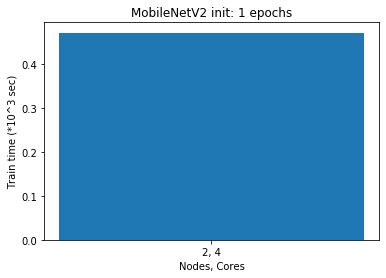

In [0]:
visualize_grid_search(f"{name} init", init_epochs, results_init4)

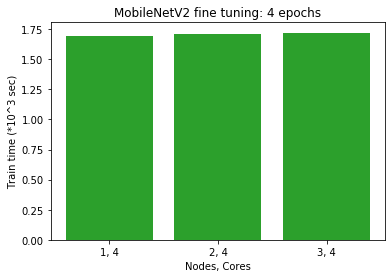

In [0]:
visualize_grid_search(f"{name} fine tuning", fine_tuning_epochs, results_fine_tuning4)

In [0]:
tabulate_grid_search(f"{name} fine tuning", fine_tuning_epochs, results_fine_tuning4)

MobileNetV2 fine tuning
 Nodes, Cores | fit_time (sec) |
----------------|------------------|
 1, 4 | 1695.01 |
 2, 4 | 1708.17 |
 3, 4 | 1720.31 |